In [64]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def tank_improved(z,t,min,tin,cp,q,rho,g,r,a):
    h = z[0]
    te = z[1]
    dhdt = (1/a) * ((min/rho) - (rho*g*h/r))
    dTdt = (min/(rho*rho*g*h/r))*tin - te + q/(cp*(rho*rho*g*h/r))
    dzdt = [dhdt,dTdt]
    return dzdt


In [66]:
# heater model parameters
t = np.linspace(0,500,5000)

tin = 293.15
#q = 150000
cp = 4.2

# tank model parameters 
min = 3000.0
h0 = 4
rho = 1000
# r = 20000
a = np.pi * 1.5**2
g = 9.8

In [67]:
### TEST MODEL SETUP ###
# z = odeint(tank_improved,z0,t,args=(min,tin,cp,q,rho,g,r,a,))
# h = z[:,0]
# te = z[:,1]
# te = te - 273.15
# print(z)

In [127]:
## control system
sp_te = np.ones(len(t)) * (65.0 + 273.15)
sp_te[:10] = 0

sp_h = np.ones(len(t)) * 6
sp_h[2000:] = 4

error_te = np.zeros(len(t))
error_h = np.zeros(len(t))

# PID parameters 1-->h and 2-->te
Dsum = [0.0, 0.0]
Isum = [0.0, 0.0]
LastError = [0.0, 0.0]

kc = [5.2, 10.8]
taui = [1.0, 0.30]
taud = [5.0, 5.0]

In [128]:
#controllable variables
q = np.zeros(len(t))
#q[100:] = 150000

r = np.ones(len(t))*20000

In [129]:
z0 = [h0,tin]
h=np.zeros(len(t))
te=np.zeros(len(t))
h[0] = h0
te[0] = tin
for i in range (len(t)-1):
    #-------------------------------------------------------------------------------#
    error_h[i] = sp_h[i] - z0[0]
    error_te[i] = sp_te[i] - z0[1]

    Isum[0] = Isum[0] + (kc[0]/taui[0])*error_h[i]
    Isum[1] = Isum[1] + (kc[1]/taui[1])*error_te[i]

    Dsum[0] = (kc[0]/taud[0])*(error_h[i] - LastError[0])
    Dsum[1] = (kc[1]/taud[1])*(error_te[i] - LastError[1])

    r[i] = r[0] + kc[0]*error_h[i] + Isum[0] + Dsum[0]
    q[i] = q[0] + kc[1]*error_te[i] + Isum[1] + Dsum[1]
    #-------------------------------------------------------------------------------#
    z = odeint(tank_improved,z0,[t[i],t[i+1]],args=(min,tin,cp,q[i],rho,g,r[i],a,))
    z0 = z[1]
    #print(z[1])
    h[i+1] = z[1,0]
    te[i+1] = z[1,1]

    LastError[0] = error_h[i]
    LastError[1] = error_te[i]
    
#te = te - 273.15

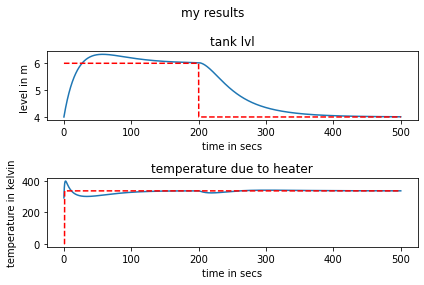

In [155]:
fig, ax = plt.subplots(2)

fig.suptitle('my results')

ax[0].plot(t, h)
ax[0].plot(t,sp_h,'r--')
ax[0].set_title("tank lvl")
ax[0].set_xlabel('time in secs')
ax[0].set_ylabel('level in m ')

ax[1].sharex(ax[0])
ax[1].plot(t, te)
ax[1].plot(t,sp_te,'r--')
ax[1].set_title("temperature due to heater")
ax[1].set_xlabel('time in secs')
ax[1].set_ylabel('temperature in kelvin')
fig.tight_layout()

plt.show()